<a href="https://www.kaggle.com/code/kaiyoo88/tutorial-digit-recognizer?scriptVersionId=202456163" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt
# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/digit-recognizer/sample_submission.csv
/kaggle/input/digit-recognizer/train.csv
/kaggle/input/digit-recognizer/test.csv


In [2]:
#import train and test CSV files
train_csv_loc = "/kaggle/input/digit-recognizer/train.csv"
test_csv_loc = "/kaggle/input/digit-recognizer/test.csv"
train = pd.read_csv(train_csv_loc)
test = pd.read_csv(test_csv_loc)

train.head()

,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [5]:
from sklearn.model_selection import train_test_split

# Split the train set so there is also a validation set
train_x, val_x, train_y, val_y = train_test_split(train.iloc[:, 1:], 
                                                  train.iloc[:, 0], 
                                                  test_size=0.2) 

# Reset indices so the Dataset can find them with __getitem__ easily
train_x.reset_index(drop=True, inplace=True)
val_x.reset_index(drop=True, inplace=True)
train_y.reset_index(drop=True, inplace=True)
val_y.reset_index(drop=True, inplace=True)

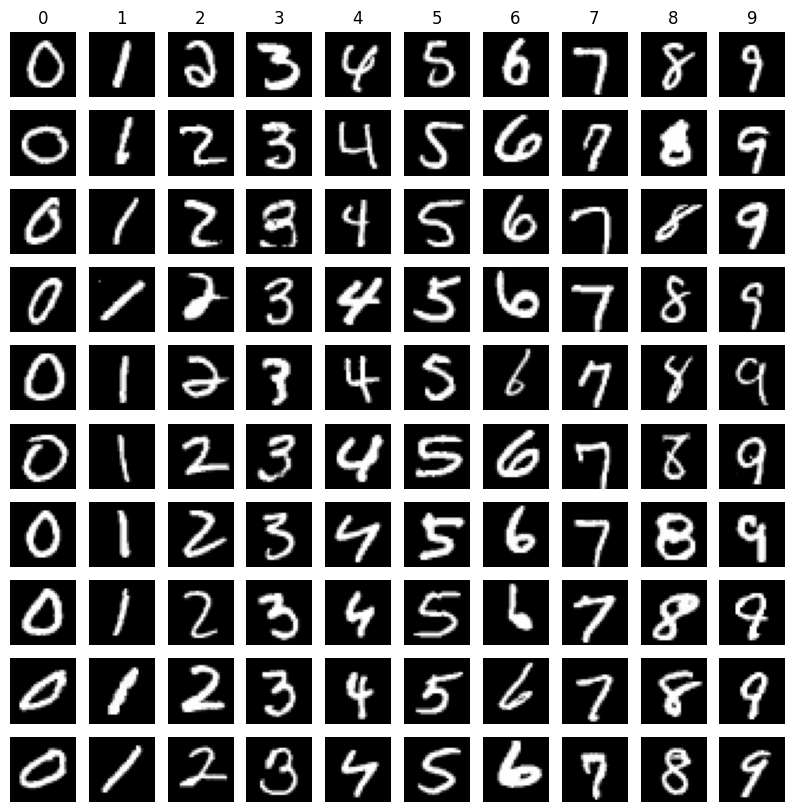

In [7]:
# Some more quick data visualization
# First 10 images of each class in the training set
fig, ax = plt.subplots(nrows=10, ncols=10, figsize=(10,10))

for i in range(10): # Column by column
    num_i = train_x[train_y == i]
    ax[0][i].set_title(i)
    for j in range(10): # Row by row
        ax[j][i].axis('off')
        ax[j][i].imshow(num_i.iloc[j, :].to_numpy().astype(np.uint8).reshape(28, 28), cmap='gray')

In [10]:
from torch.utils.data import Dataset

class MNISTDataSet(Dataset):
    # images df, labels df, transforms
    # uses labels to determine if it needs to return X & y or just X in __getitem__
    def __init__(self, images, labels, transforms=None):
        self.X = images
        self.y = labels
        self.transforms = transforms
                    
    def __len__(self):
        return len(self.X)
    
    def __getitem__(self, i):
        data = self.X.iloc[i, :] # gets the row
        # reshape the row into the image size 
        # (numpy arrays have the color channels dim last)
        data = np.array(data).astype(np.uint8).reshape(28, 28, 1) 
        
        # perform transforms if there are any
        if self.transforms:
            data = self.transforms(data)
        
        # if !test_set return the label as well, otherwise don't
        if self.y is not None: # train/val
            return (data, self.y[i])
        else: # test
            return data

In [12]:
import torch
import torchvision
from torchvision import datasets, transforms
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn

transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,))
                   ])

# Get datasets using the custom MNIST Dataset for the train, val, and test images
train_dataset = MNISTDataSet(train_x, train_y, transform)
val_dataset = MNISTDataSet(val_x, val_y, transform)
test_dataset = MNISTDataSet(test, None, transform)

# Nice habit to get into
num_classes = 10 # 0-9

In [127]:
train_csv_loc

'/kaggle/input/digit-recognizer/train.csv'

In [13]:
# train_dataset, val_dataset = torch.utils.data.random_split(train_dataset, [train_size, val_size])
# print(len(train_dataset), len(val_dataset), len(test_dataset))
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=128, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=128, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=128, shuffle=False)

In [14]:
train_iter = iter(train_loader)
print(type(train_iter))

images, labels = next(train_iter)

print('images shape on batch size = {}'.format(images.size()))
print('labels shape on batch size = {}'.format(labels.size()))

<class 'torch.utils.data.dataloader._SingleProcessDataLoaderIter'>
images shape on batch size = torch.Size([128, 1, 28, 28])
labels shape on batch size = torch.Size([128])


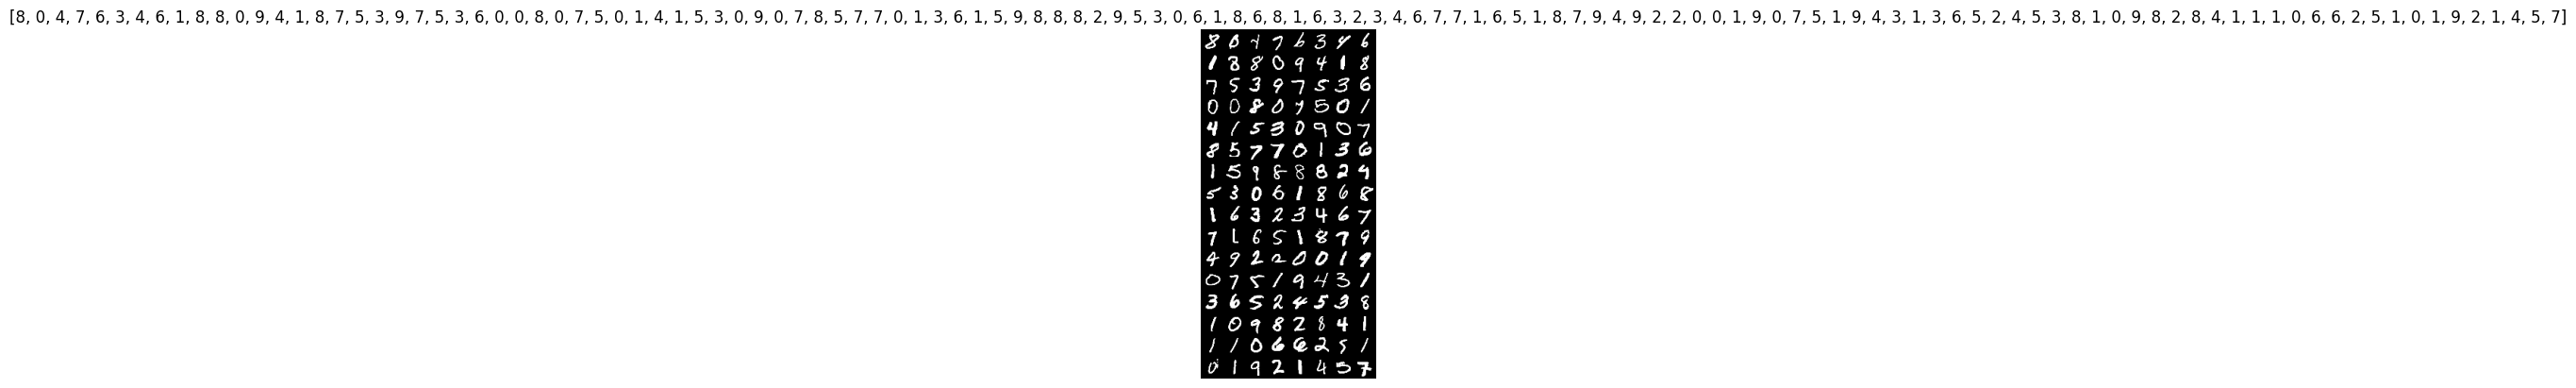

In [15]:
# make grid takes tensor as arg
# tensor : (batchsize, channels, height, width)
grid = torchvision.utils.make_grid(images)

plt.imshow(grid.numpy().transpose((1, 2, 0)))
plt.axis('off')
plt.title(labels.tolist());

In [17]:
class LinearModel(nn.Module):
    def __init__(self): 
        super(LinearModel, self).__init__()
        self.linear = nn.Linear(in_features=784, out_features=10, bias=True)
    
    def forward(self, x):
        x = self.linear(x)
        return x

In [18]:
cls_loss = nn.CrossEntropyLoss()

In [24]:
import torch.optim as optim
from sklearn.metrics import accuracy_score

# ====== Construct Model ====== #
model = LinearModel()
print('Number of {} parameters'.format(sum(p.numel() for p in model.parameters() if p.requires_grad)))

# ===== Construct Optimizer ====== #
lr = 0.005 
optimizer = optim.SGD(model.parameters(), lr=lr) 

list_epoch = [] 
list_train_loss = []
list_val_loss = []
list_acc = []
list_acc_epoch = []

epoch = 10 #30
for i in range(epoch):
    
    # ====== Train ====== #
    train_loss = 0
    model.train() 
    
    for input_X, true_y in train_loader:
        optimizer.zero_grad() # [21.01.05 오류 수정] 매 Epoch 마다 .zero_grad()가 실행되는 것을 매 iteration 마다 실행되도록 수정했습니다. 

        input_X = input_X.squeeze()
        input_X = input_X.view(-1, 784)
        pred_y = model(input_X)

        loss = cls_loss(pred_y.squeeze(), true_y)
        loss.backward() 
        optimizer.step() 
        train_loss += loss.detach().numpy()
    train_loss = train_loss / len(train_loader)
    list_train_loss.append(train_loss)
    list_epoch.append(i)
    
    
    # ====== Validation ====== #
    val_loss = 0
    correct = 0
    model.eval()
    # optimizer.zero_grad() [21.01.05 코드 클린업] 아래 torch.no_grad()가 호출되고 Validation 과정에서는 Optimizer를 사용하지 않으므로 굳이 호출될 필요가 없습니다. 
    
    with torch.no_grad(): # [21.01.05 코드 클린업] Validation 과정에서 그라디언트가 활용되지 않도록 torch.no_grad() statement 안에서 코드를 실행합니다.
        for input_X, true_y in val_loader:
            input_X = input_X.squeeze()
            input_X = input_X.view(-1, 784)
            pred_y = model(input_X)

            loss = cls_loss(pred_y.squeeze(), true_y)
            val_loss += loss.detach().numpy()

            def get_num_correct(preds, labels):
                return preds.argmax(dim=1).eq(labels).sum().item()

            # correct += pred_y.eq(true_y).sum()
            correct += get_num_correct(pred_y, true_y)
            
        val_loss = val_loss / len(val_loader)
        list_val_loss.append(val_loss)

        acc = correct / len(val_loader.dataset)
        list_acc.append(acc)
        list_acc_epoch.append(i)

    print('Epoch: {}, Train Loss: {}, Val Loss: {}, Test Acc: {}%'.format(i, train_loss, val_loss, acc*100))

Number of 7850 parameters
Epoch: 0, Train Loss: 0.8668247873792176, Val Loss: 0.545390369314136, Test Acc: 86.14285714285714%
Epoch: 1, Train Loss: 0.48535928776055687, Val Loss: 0.44685057934486505, Test Acc: 88.10714285714286%
Epoch: 2, Train Loss: 0.4215553490154643, Val Loss: 0.40641781642581476, Test Acc: 89.25%
Epoch: 3, Train Loss: 0.3901829395457366, Val Loss: 0.38422366254257434, Test Acc: 89.69047619047619%
Epoch: 4, Train Loss: 0.37035005491496037, Val Loss: 0.36892744131160504, Test Acc: 89.90476190476191%
Epoch: 5, Train Loss: 0.35647063274573915, Val Loss: 0.35812152289982996, Test Acc: 90.05952380952381%
Epoch: 6, Train Loss: 0.34600187311154357, Val Loss: 0.34978444671089, Test Acc: 90.27380952380952%
Epoch: 7, Train Loss: 0.33782359867041556, Val Loss: 0.3437344388979854, Test Acc: 90.40476190476191%
Epoch: 8, Train Loss: 0.3308776489568754, Val Loss: 0.33761368827386334, Test Acc: 90.57142857142857%
Epoch: 9, Train Loss: 0.3249324245711243, Val Loss: 0.333374495533379

KeyboardInterrupt: 

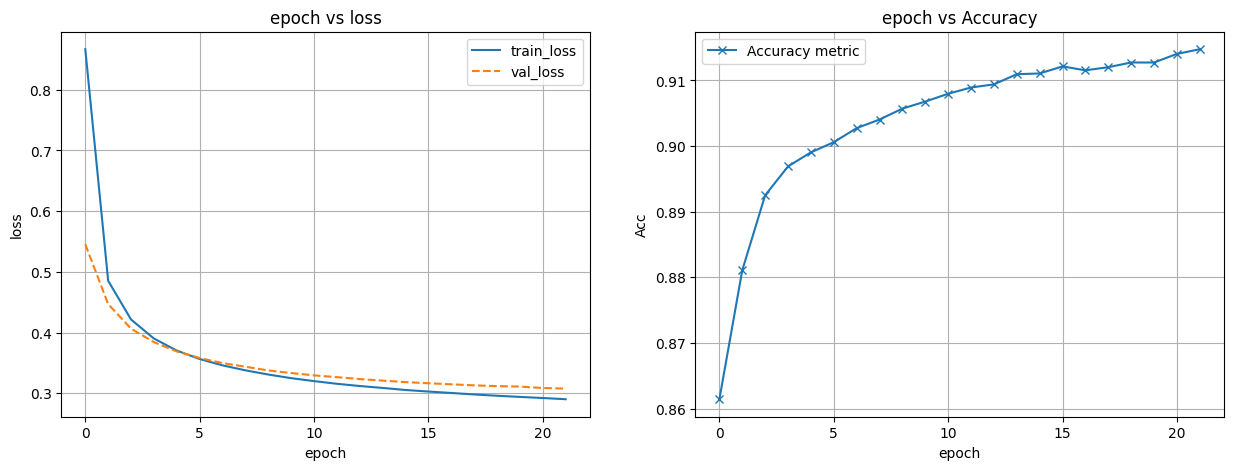

In [25]:
fig = plt.figure(figsize=(15,5))

# ====== Loss Fluctuation ====== #
ax1 = fig.add_subplot(1, 2, 1)
ax1.plot(list_epoch, list_train_loss, label='train_loss')
ax1.plot(list_epoch, list_val_loss, '--', label='val_loss')
ax1.set_xlabel('epoch')
ax1.set_ylabel('loss')
ax1.grid()
ax1.legend()
ax1.set_title('epoch vs loss')

# ====== Metric Fluctuation ====== #
ax2 = fig.add_subplot(1, 2, 2)
ax2.plot(list_acc_epoch, list_acc, marker='x', label='Accuracy metric')
ax2.set_xlabel('epoch')
ax2.set_ylabel('Acc')
ax2.grid()
ax2.legend()
ax2.set_title('epoch vs Accuracy')

plt.show()